In [1]:
import sys
import math
import itertools
import random
import time
from functools import lru_cache
from collections import deque
import matplotlib.pyplot as plt

In [2]:
#varijable za random graf
density = 0.5 #koliko cesto ce biti generisana grana izmedju cvorova
a = 1  #min tezina grane
b = 10 #max tezina grane
n = 10 #broj cvorova

In [3]:
def generateRandomGraph(n):
    graph = []

    #napravi graf tako da bude povezan
    for i in range(n):
        j = (i+1) % n
        w = random.randint(a,b)
        graph.append((i,j,w))

    #dodaj nasumicne grane
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < density and (i,j,_) not in graph:
                w = random.randint(a,b)
                graph.append((i,j,w))
    return graph

In [4]:
g = generateRandomGraph(n)
print(g)
print(len(g))

[(0, 1, 9), (1, 2, 8), (2, 3, 1), (3, 4, 4), (4, 5, 1), (5, 6, 2), (6, 7, 2), (7, 8, 6), (8, 9, 7), (9, 0, 2), (0, 1, 3), (0, 6, 4), (0, 7, 9), (0, 9, 10), (1, 9, 2), (2, 3, 9), (2, 5, 9), (2, 6, 7), (2, 7, 2), (2, 8, 2), (3, 7, 6), (3, 8, 6), (3, 9, 7), (4, 5, 9), (4, 6, 10), (4, 9, 2), (5, 9, 4), (6, 9, 7), (7, 8, 7), (8, 9, 1)]
30


In [5]:
def floydWarshall(n, graph):
    D = [[math.inf]*n for _ in range(n)]
    #dijagonale se popune nulom
    for i in range(n):
        D[i][i] = 0

    #trazimo minimum izmedju svaka dva povezana cvora
    for i, j, w in graph:
        D[i][j] = min(D[i][j], w)
        D[j][i] = min(D[j][i], w)

    #trazimo najkraci put izmedju svaka dva cvora kao min trenutnog rezultata i puta preko nekog treceg cvora
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if D[i][j] > D[i][k] + D[k][j]:
                    D[i][j] = D[i][k] + D[k][j]

    return D

In [6]:
D = floydWarshall(n, g)
print(D)

[[0, 3, 5, 6, 4, 5, 4, 6, 3, 2], [3, 0, 5, 6, 4, 5, 7, 7, 3, 2], [5, 5, 0, 1, 5, 6, 4, 2, 2, 3], [6, 6, 1, 0, 4, 5, 5, 3, 3, 4], [4, 4, 5, 4, 0, 1, 3, 5, 3, 2], [5, 5, 6, 5, 1, 0, 2, 4, 4, 3], [4, 7, 4, 5, 3, 2, 0, 2, 6, 5], [6, 7, 2, 3, 5, 4, 2, 0, 4, 5], [3, 3, 2, 3, 3, 4, 6, 4, 0, 1], [2, 2, 3, 4, 2, 3, 5, 5, 1, 0]]


In [7]:
def oddDegVertices(n, edges):
    deg = [0]*n #pravi praznu matricu
    for u, v, _ in edges:
        #povecava stepen za 1, ako je neparan na kraju cvor ce biti u listi
        deg[u] += 1
        deg[v] += 1
    return [i for i in range(n) if deg[i] % 2 == 1] #vrati one cvorove koji imaju neparan stepen(neparan broj suseda, tj izlaznih grana)

In [8]:
def minCost(odd_vertices, D):
    """
    Bitmask
    Minimalan trosak da se cvorovi sa neparnim stepenom upare
    odd_vertices - lista cvorova sa neparnim stepenom
    D - matrica gde je D[i][j] tezina najkraceg puta izmedju i i j
    """
    if not odd_vertices:
        return 0

    #uvek ce biti paran broj cvorova pa nema potrebe za proverom(Lema)
    n = len(odd_vertices)
    memo = {}
    
    #@lru_cache(maxsize=None)
    def dp(mask):
        if mask == (1 << n) - 1: #ako su svi cvorovi upareni
            return 0
        if mask in memo:
            return memo[mask]
        #nadji prvi neupareni
        for i in range(n):
            if not (mask & (1 << i)):
                break
    
        best = math.inf
        for j in range(i+1, n):
            if not (mask & (1 << j)):
                cost = D[odd_vertices[i]][odd_vertices[j]] + dp(mask | (1 << i) | (1 << j)) #maska pokazuje da su upareni i i j cvorovi
                best = min(best, cost)
        memo[mask] = best
        return best
    return dp(0)

In [9]:
def connectedComponents(edges, n):
    #Vraca listu povezanih komponenti iz ciklusa
    #Uredjeni par mape cvorova i grana(trojka cvor,cvor,tezina)
    #za svaki cvor imamo listu suseda
    adj = [[] for _ in range(n)]
    #da li je cvor obidjen u ovom ciklusu
    nodes = [False]*n
    for u,v,w in edges:
        adj[u].append(v)
        adj[v].append(u)
        nodes[u] = nodes[v] = True
    #povezane komponente
    comps = []
    visited = [False]*n
    #prolazak kroz sve cvorove
    for u in range(n):
        if nodes[u] and not visited[u]:
            #BFS pretraga grafa
            q = deque([u])
            visited[u] = True
            comp_nodes = {u}

            while q:
                t = q.popleft()
                for el in adj[u]:
                    if not visited[el]:
                        visited[el] = True
                        comp_nodes.add(el)
                        q.append(el)

            comp_edges = []
            for i, j, k in edges:
                if i in comp_nodes:
                    comp_edges.append((i,j,k))
            comps.append((comp_nodes, comp_edges))
    return comps

In [10]:
def connectComponentsCost(comp_start_idx, comp_count, D):
    #trazimo najjeftiniji nacin da povezemo sve komponente sa startnom komponentom
    idxs = list(range(comp_count))
    best = math.inf
    if comp_count == 0:
        return 0
    #ako nemamo startnu komponentu(nijedna ne sadrzi startni cvor)
    if comp_start_idx is None:
        #probamo cikluse sa fiksiranim prvim elementom da ne dodje do ponavljanja
        first = 0
        others = [i for i in idxs if i != first]
        for p in itertools.permutations(others):
            sequence = [first] + list(p) + [first]
            cost = 0
            for u,v in zip(sequence[:-1], sequence[1:]):
                cost += D[u][v]
            if cost < best:
                best = cost
    else:
        others = [i for i in idxs if i != comp_start_idx]
        for p in itertools.permutations(others):
            sequence = [comp_start_idx] + list(p) + [comp_start_idx]
            cost = 0
            for u,v in zip(sequence[:-1], sequence[1:]):
                cost += D[u][v]
            if cost < best:
                best = cost
    return best

In [11]:
def lengthCPP(edges, n, D, start):
    #racuna zbir tezina svih grana koje cine ciklus + cenu da se sve povezane komponente ciklusa povezu
    #ako nemamo granu vracamo nulu
    if not edges:
        return 0

    best_sum = sum(w for _,_,w in edges)
    comps = connectedComponents(edges, n)
    comp_count = len(comps)

    #cena da se obidje cela komponenta i cvorovi koji se nalaze u komponenti
    comp_costs = []
    comp_nodes = []
    for nodes, comp_edges in comps:
        comp_nodes.append(nodes)
        #suma tezina grana u komponenti
        comp_sum = sum(w for _,_,w in comp_edges)
        #cvorovi sa neparnim stepenom u komponenti
        odd = oddDegVertices(n, comp_edges)
        connect_cost = minCost(odd, D)
        comp_costs.append(comp_sum + connect_cost)

    #ako postoji samo jedna komponenta i nije povezana sa startom, moramo je povezati sa startom i vratiti se nazad na kraju
    #pravimo matricu minimalnih distanci svih cvorova iz komponente A sa svim cvorovima iz komponente B
    comp_D = [[0]*comp_count for _ in range(comp_count)]
    for i in range(comp_count):
        for j in range(comp_count):
            if i==j:
                comp_D[i][j] = 0
            else:
                best = math.inf
                for u in comp_nodes[i]:
                    for v in comp_nodes[j]:
                        if best > D[u][v]:
                            best = D[u][v]
                comp_D[i][j] = best

    #trazimo koja komponenta ovog ciklusa sadrzi start(ako postoji)
    comp_start_idx = None
    for i, (nodes, _) in enumerate(comps):
        if start in nodes:
            comp_start_idx = i
            break
            
    #ako start ne pripada nijednoj komponenti nego je izolovan, moramo ga povezati sa nekom komponentom
    start_connection_cost = 0
    if comp_start_idx is None:
        start_to_comp = []
        for nodes in comp_nodes:
            best = math.inf
            for u in nodes:
                if D[start][u] < best:
                    best = D[start][u]
            start_to_comp.append(best)
        #treba izabrati koju komponentu povezati sa startom i posle obici sve ostale komponente
        #(koje potencijalno takodje nisu povezane)
        best_total = math.inf
        for i in range(comp_count):
            #cena da idemo od starta do komponente i + obilzak svih ostalih komponenti pocev od komponente i
            # + povratak u komponentu i + povratak iz komponente i do starta
            cost = connectComponentsCost(i, comp_count, comp_D)
            total = start_to_comp[i] + cost + start_to_comp[i]
            if total < best_total:
                best_total = total
        comp_travel_cost = best_total
    else:
        comp_travel_cost = connectComponentsCost(comp_start_idx, comp_count, comp_D)

    return sum(comp_costs) + comp_travel_cost

In [12]:
def bruteForceCPP(start, k, n, graph):
    """
    Backtrack dodaje svaku granu u ciklus nekog postara
    Ako je trnutno resenje gore od trenutno najboljeg pronadjenog, prekidamo backtrack i krecemo novi
    Svaki postar dobije jedan ciklus
    """
    D = floydWarshall(n, graph) #matrica gde d[i][j] najkraci put izmedju i i j
    edge_weights = [w for (_,_,w) in graph]
    best = math.inf #najbolje resenje
    m = len(graph) #broj grana
    current_sums = [0]*k #sume po ciklusu
    cycles = [[] for _ in range(k)] #cycle za svakog postara(broj grane iz graph koja je deo ciklus)

    #rekurzivna funkcija koja odseca ako ciklus ne moze biti najbolji
    #edge_idx - indeks grane, num_cycles - broj aktivnih ciklusa(oni koji imaju bar jednu granu dodatu)
    def backtrack(edge_idx, num_cycles):
        nonlocal best
        
        #trenutno resenje
        current_max = max(current_sums[:num_cycles]) if num_cycles > 0 else 0
        
        #ako je trenutno resenje gore od najboljeg pronadjenog, zavrsi backtrack
        if current_max >= best:
            return
        
        #provera da li smo sve grane stavili u neki ciklus
        if edge_idx == m:
            cycle_lengths = []
            #prolazak kroz svakog postara
            for p in range(k):
                #ako je postarev ciklus prazan dodaj nulu za lenght
                if not cycles[p]:
                    cycle_lengths.append(0)
                else:
                    #pravimo listu grana koje su deo ciklusa ovog postara
                    edges = [graph[i] for i in cycles[p]]
                    #funkcija racuna sumu tezina svih grana koje su deo ciklusa
                    L = lengthCPP(edges, n, D, start)
                    cycle_lengths.append(L)
            max_len = max(cycle_lengths)
            if max_len < best:
                best = max_len
            return

        #idemo redom kroz sve postare i trazimo najboljeg da mu dodelimo trenutnu granu
        for p in range(num_cycles+1):
            if p>=k: break

            #update trenutne sume grana u ciklusu trenutnog postara
            current_sums[p] += edge_weights[edge_idx]
            cycles[p].append(edge_idx)
            new_num_cycles = num_cycles + (1 if p == num_cycles else 0)
            #ako je trenutno resenje bolje od trenutnog najboljeg idemo dalje
            if max(current_sums[:new_num_cycles]) < best:
                backtrack(edge_idx+1, new_num_cycles)
            #undo update
            current_sums[p] -= edge_weights[edge_idx]
            cycles[p].pop()

            #provera da se ne dogodi slucaj da krenemo 2 nova ciklusa u isto vreme
            #odnosno da trenutnu granu kada dodamo u novi ciklus ne probamo da dodamo u jos jedan novi ciklus
            if p == num_cycles:
                break

    backtrack(0,0)
    return best

In [13]:
if __name__ == "__main__":
    n = 5
    graph = generateRandomGraph(n)
    start = 0
    k = 2
    print("Graph:", graph)
    best = bruteForceCPP(start, k, n, graph)
    print("Max cycle length:", best)

Graph: [(0, 1, 4), (1, 2, 9), (2, 3, 6), (3, 4, 10), (4, 0, 9), (0, 3, 1), (1, 2, 10), (1, 4, 7)]
Max cycle length: 42


In [14]:
"""
Cycle-Trade heuristika za kineskog postara
1. Raspodeli grane u k ciklusa za svakog od k postara
2. Trade: prebaci deo grana iz jednog ciklusa u drugi ili zameni grane izmedju 2 postara
3. Tabu list: cuva poteze koji su nedavno uradjeni
4. Cilj je minimizovati max(len_cycle)
5. Zaustavlja se kada prodje odredjen broj iteracija bez poboljsanja ili istekne zadato vreme
"""

'\nCycle-Trade heuristika za kineskog postara\n1. Raspodeli grane u k ciklusa za svakog od k postara\n2. Trade: prebaci deo grana iz jednog ciklusa u drugi ili zameni grane izmedju 2 postara\n3. Tabu list: cuva poteze koji su nedavno uradjeni\n4. Cilj je minimizovati max(len_cycle)\n5. Zaustavlja se kada prodje odredjen broj iteracija bez poboljsanja ili istekne zadato vreme\n'

In [15]:
def generateConnectedGraph(n, extra_edges=20, a=1, b=10):
    graph = []

    #kreira lanac koji povezuje sve cvorove
    for i in range(n-1):
        w = random.randint(a,b)
        graph.append((i, i+1, w))

    #spoja prvi i poslednji cvor i formira ciklus
    graph.append((0, n-1, random.randint(a,b)))

    #dodaje nasumicne grane bez duplikata
    added_edges = set((min(u,v), max(u,v)) for u,v,_ in graph)
    attempts = 0
    while len(added_edges) < n-1 + 1 + extra_edges and attempts < extra_edges*5:
        u, v = random.sample(range(n), 2)
        if (min(u,v), max(u,v)) not in added_edges:
            w = random.randint(a,b)
            graph.append((u, v, w))
            added_edges.add((min(u,v), max(u,v)))
        attempts += 1

    return graph


In [16]:
def initialSolution(m, k):
    #nasumicno dodeli svaku granu nekom postaru
    return [random.randint(0, k-1) for _ in range(m)]

In [17]:
def lengthCycle(edges, n, D, start):
    #racuna duzinu ciklusa
    #dodao sam penalty jer moze da se desi da podgraf ima neparan broj cvorova neparnog stepena
    #da ne bih dodavao start 2 puta penalty=10**6
    if not edges:
        return 0
    odd = oddDegVertices(n, edges)
    #ako start nije deo ciklusa moramo ga dodati
    if start not in odd:
        odd.append(start)

    if len(odd) % 2 == 1:
        #print(f"[PENALTY] Neparan broj neparnih čvorova: odd={odd}")
        #return sum(w for _,_,w in edges) + penalty
        odd.append(start)
    
    cost = minCost(odd, D)
    #if cost == math.inf:
        #print(f"[PENALTY] minCost dao INF za odd={odd}")
        #print(f"[WARN] minCost dao INF čak i za parni odd={odd}")
        #return sum(w for _,_,w in edges) + penalty
    
    return sum(w for _,_,w in edges) + cost

In [18]:
def tabuSolution(solution, start, k, n, graph, D):
    #trazi max duzinu ciklusa
    cycles = [[] for _ in range(k)]
    for edge_idx, p in enumerate(solution):
        cycles[p].append(graph[edge_idx])
    lengths = [lengthCycle(cycle, n, D, start) if cycle else 0 for cycle in cycles]
    """
    for c in cycles:
        if c:
            l = lengthCPP(c, n, D, start)
        else:
            l = 0
        lengths.append(l)
    """
    return max(lengths), lengths

In [19]:
def tabuSolutionIncremental(solution, start, n, graph, D, lengths, move):
    #update samo dva postara na koja smo primenili move
    edge_idx, p1, p2 = move
    new_lengths = lengths[:]

    # stari i novi ciklus
    old_cycle = [graph[i] for i, p in enumerate(solution) if p == p1 and i != edge_idx]
    new_cycle = [graph[i] for i, p in enumerate(solution) if p == p2] + [graph[edge_idx]]

    new_lengths[p1] = lengthCycle(old_cycle, n, D, start) if old_cycle else 0
    new_lengths[p2] = lengthCycle(new_cycle, n, D, start)

    return max(new_lengths), new_lengths

In [20]:
def tabuNeighbors(solution, k, max_neighbors = None):
    if solution is None:
        print("ERROR: solution je None u tabuNeighbors!")
    #generisi susede - cycle trades, opciono moze da se ogranici broj
    m = len(solution)
    all_moves = []
    #za svaku granu posmatramo kom postaru je dodeljena
    for i in range(m):
        current_postman = solution[i]
        for p in range(k):
            if p != current_postman:
                all_moves.append((i, current_postman, p))

    if max_neighbors is not None and len(all_moves) > max_neighbors:
        all_moves = random.sample(all_moves, max_neighbors)

    return all_moves

In [21]:
def cycleTrade(start, k, n, graph, max_iter=120, tabu_capacity=15, max_neighbors=50):
    #cycle-trade tabu search
    D = floydWarshall(n, graph) #matrica najkracih puteva
    m = len(graph) #broj grana

    current = initialSolution(m, k) #pocetno resenje
    if current is None:
            print(f"[DEBUG] Iteracija {i}: Nema kandidata, current={current}")
    
    current_value, current_lengths = tabuSolution(current, start, k, n, graph, D)

    best = current[:]
    best_value = current_value
    history = [best_value]

    #tabu list FIFO
    tabu = deque(maxlen=tabu_capacity)

    #merenje vremena izvrsavanja
    start_time = time.time()
    iter_times = []
    
    for i in range(max_iter):
        iter_start = time.time()
        
        candidate = None
        candidate_value = math.inf
        candidate_move = None
        candidate_lengths = None

        #generisi susede
        for move in tabuNeighbors(current, k, max_neighbors=max_neighbors):
            #ako smo vec uradili move preskacemo ga
            if move in tabu:
                continue

            value, new_lengths = tabuSolutionIncremental(current, start, n, graph, D, current_lengths, move)
            if value == math.inf:
                    continue
            if value < candidate_value:
                candidate = current[:]
                candidate[move[0]] = move[2] #primeni move
                candidate_value = value
                candidate_move = move
                candidate_lengths = new_lengths

        #ako su svi susedi u tabu, uzmi najbolji tabu
        if candidate is None:
            for move in tabuNeighbors(current, k, max_neighbors=max_neighbors):
                value, new_lengths = tabuSolutionIncremental(current, start, n, graph, D, current_lengths, move)
                if value == math.inf:
                    continue
                if value < candidate_value:
                    candidate = current[:]
                    candidate[move[0]] = move[2] #primeni move
                    candidate_value = value
                    candidate_move = move
                    candidate_lengths = new_lengths 

        
        if candidate is None:
            print(f"[DEBUG] Iteracija {i}: Nema kandidata, current={current}")
            break
        
        
        #update
        current = candidate
        current_value = candidate_value
        current_lengths = candidate_lengths
        tabu.append(candidate_move)

        if current_value < best_value:
            best = current[:]
            best_value = current_value

        history.append(current_value)

        iter_time = time.time() - iter_start
        iter_times.append(iter_time)

    total_time = time.time() - start_time
    
    return best, best_value, history, iter_times, total_time

Graph: [(0, 1, 10), (1, 2, 3), (2, 3, 10), (3, 4, 8), (4, 5, 3), (5, 6, 3), (6, 7, 5), (7, 8, 2), (8, 9, 1), (9, 10, 2), (10, 11, 2), (11, 12, 1), (12, 13, 9), (13, 14, 6), (14, 15, 8), (15, 16, 4), (16, 17, 1), (17, 18, 9), (18, 19, 5), (19, 20, 10), (20, 21, 8), (21, 22, 9), (22, 23, 4), (0, 23, 3), (15, 3, 2), (23, 19, 5), (10, 3, 10), (16, 0, 1), (3, 21, 9), (9, 2, 8), (9, 0, 7), (10, 22, 2), (2, 0, 1), (4, 19, 5), (15, 1, 6), (8, 14, 2), (11, 15, 6), (21, 0, 4), (3, 6, 10)]
Best solution cycle-trade: [1, 2, 2, 1, 0, 1, 0, 7, 5, 2, 7, 3, 6, 6, 5, 5, 7, 7, 7, 4, 4, 3, 5, 5, 4, 2, 3, 4, 3, 6, 6, 5, 4, 5, 2, 6, 0, 0, 1]
Best result: 39
Time: 1.346 s


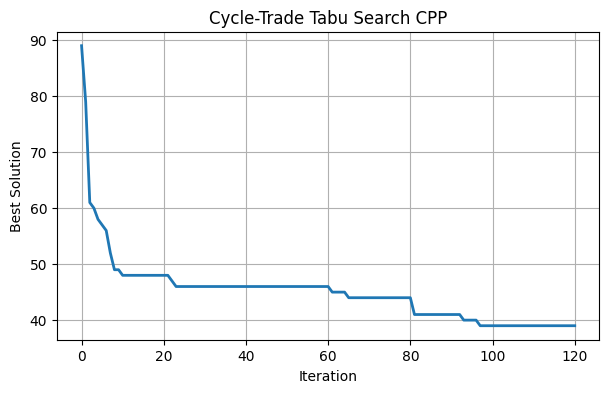

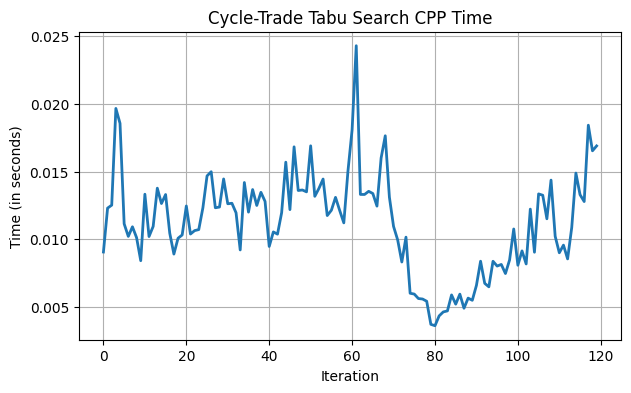

In [22]:
if __name__ == "__main__":
    n = 24
    graph = generateConnectedGraph(n, extra_edges = 15)
    start = 0
    k = 8

    D = floydWarshall(n, graph)
    for i in range(n):
        for j in range(n):
            if D[i][j] == math.inf:
                print(f"Ne postoji put između {i} i {j}")
        
    print("Graph:", graph)
    #bestbf = bruteForceCPP(start, k, n, graph)
    best, best_solution, history, iter_times, total_time = cycleTrade(start, k, n, graph)

    #print("Best solution brute force:", bestbf)
    print("Best solution cycle-trade:", best)
    print("Best result:", best_solution)
    print("Time:", round(total_time, 4), "s")

    plt.figure(figsize=(7,4))             
    plt.plot(history, linewidth=2)
    #plt.axhline(bestbf, color='r')
    plt.xlabel("Iteration")               
    plt.ylabel("Best Solution")        
    plt.title("Cycle-Trade Tabu Search CPP")  
    plt.grid(True)                        
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(iter_times, linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Time (in seconds)")
    plt.title("Cycle-Trade Tabu Search CPP Time")
    plt.grid(True)
    plt.show()